### Prodigy ML Task 4 ###
Develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture- based control systems.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

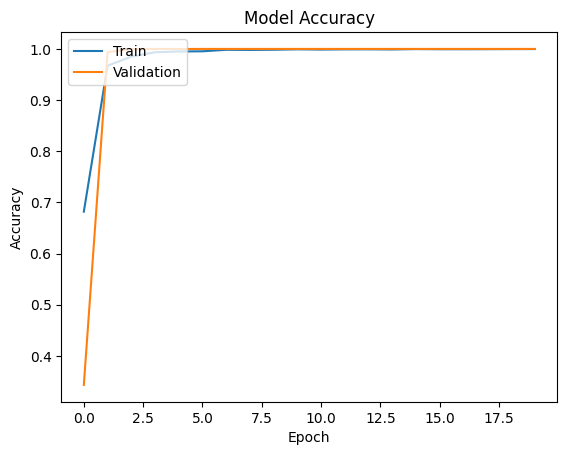

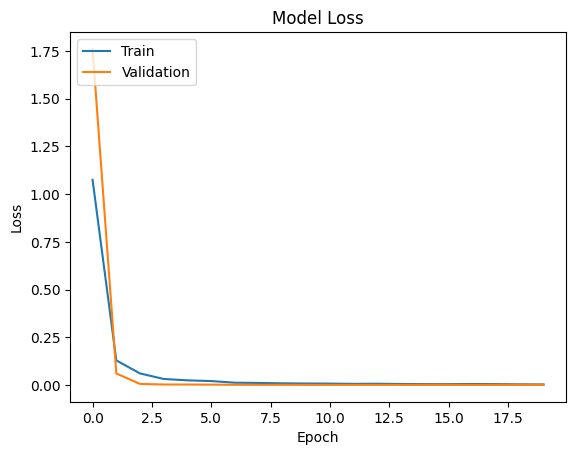

125/125 [==============================] - 87s 690ms/step
Model Accuracy: 100.00%


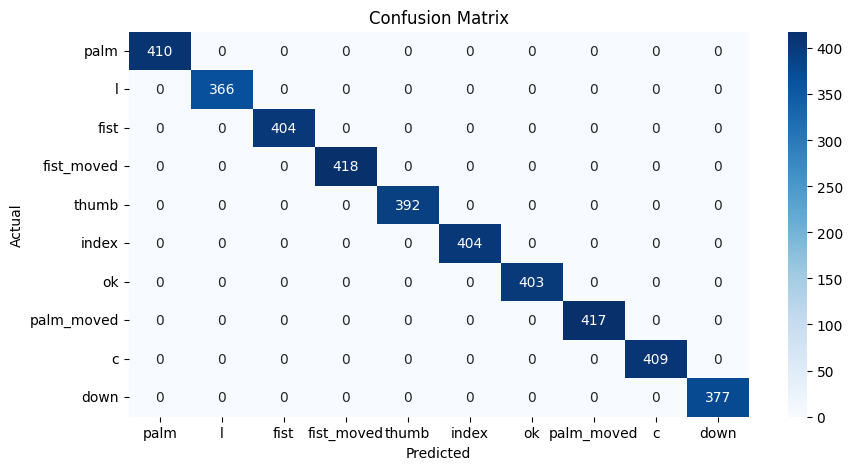

              precision    recall  f1-score   support

        palm       1.00      1.00      1.00       410
           l       1.00      1.00      1.00       366
        fist       1.00      1.00      1.00       404
  fist_moved       1.00      1.00      1.00       418
       thumb       1.00      1.00      1.00       392
       index       1.00      1.00      1.00       404
          ok       1.00      1.00      1.00       403
  palm_moved       1.00      1.00      1.00       417
           c       1.00      1.00      1.00       409
        down       1.00      1.00      1.00       377

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt

# Define the dataset path
dir = 'C:\\Study Material\\Iternship\\Prodigy\\Task 4\\archive\\leapGestRecog'

images = []
labels = []

# Iterate over each subject folder
for subject in os.listdir(dir):
    subject_path = os.path.join(dir, subject)
    
    # Iterate over each gesture folder
    for gesture in os.listdir(subject_path):
        gesture_path = os.path.join(subject_path, gesture)
        
        # Iterate over each image in the gesture folder
        for img in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img)
            image = cv2.imread(img_path)
            
            # Resize image to the desired input size
            if image is not None:
                image = cv2.resize(image, (224, 224))
                images.append(image)
                
                # Extract the label by removing the numerical prefix
                label = gesture.split('_', 1)[-1]
                labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Convert labels to one-hot encoded format
labels = pd.get_dummies(labels).values

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Data augmentation
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow(X_train, y_train, batch_size=32, shuffle=True)
val = image_gen.flow(X_val, y_val, batch_size=32, shuffle=False)
test = image_gen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Define the CNN model
model = Sequential([
    Conv2D(128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes for the 10 gestures
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model
history = model.fit(train, epochs=20, validation_data=val, verbose=1)

# Evaluate the model
model.evaluate(test, verbose=1)

# Save the model in .keras format
model.save("hand_gesture_model.keras", save_format='keras')

# Plot accuracy and loss graphs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predict and evaluate
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

y_test_labels = np.argmax(y_test, axis=1)
print(f"Model Accuracy: {np.mean(pred == y_test_labels) * 100:.2f}%")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class_labels = ['palm', 'l', 'fist', 'fist_moved', 'thumb', 'index', 'ok', 'palm_moved', 'c', 'down']

cm = confusion_matrix(y_test_labels, pred)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test_labels, pred, target_names=class_labels))
